# EZBattery demo
------------------------------------------
## Zn/I hybrid flow battery system example
------------------------------------------
## Table of contents
### 1. Import all the necessary packages
### 2. Example of simulation for a small cell
#### 2.1. Load in the cell metadata
#### 2.2. Run EZBattery model for the cell
### 3. Scale up this cell, and construct a Zn/I flow battery system
#### 3.1. The system has 60 cells. Each cell is 0.25 x 0.25 m active area
#### 3.2. Construct the system to a 3kW rated power, and 10kWh capacity system
#### 3.3. Show the cell performance at the rated power
### 4. Operate the system for a load in duty cycle
#### 4.1. Load in the one-week duty cycle
#### 4.2. Run the model for the load in one-week duty cycle. No degradation
#### 4.3. Show the voltage, current, and SOC of the system for the load in one-week duty cycle
### 5. Generate synthetic system data for a load in one-week duty cycle. With degradation
#### 5.1 Reload in the cell metadata, and set the system capacity as 3kW, 10kWh
#### 5.2. Show the results for the system runing at the load in one-week duty cycle
#### 5.3. Save the results to csv files
### 6. Diagnose the system (streaming) data
#### 6.1. Load in the system streaming data
#### 6.2. Define the loss function and optimization function
#### 6.3. Run the diagnosis framework for the load in one-week system streaming data.
#### 6.4. Show the results, comprison between the diagnostic restuls and the true "make up" degradation
#### 6.5. Estimate the system performance at rated power with diagostic degradation results
#### 6.6. Show the system performance at rated power with degradation.
------------------------------------------

### 1. Import all the necessary packages

In [1]:
import os, copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import tqdm
import matplotlib.cm as cm
from EZBattery import BatteryParameter
from EZBattery import EZBatteryCell, RFB, searchCurrent, searchSystem, systemPower

### 2. Example of simulation for a small cell
#### 2.1. Load in the cell metadata

In [2]:
WorkDir = os.getcwd() + os.sep + 'data' 
SDPFName = 'SDPF_ZIB_V5.xlsx'
SDPFPath = WorkDir + os.sep + SDPFName
PP0 = BatteryParameter(SDPFPath)

#### 2.2. Run EZBattery model for the cell
####     The test cell has 4 x 10 cm activae area

In [3]:
Re0 = RFB(PP0)

Running a multi-cycle unit cell model.
Active species: ['Iodide', 'Triiodide', 'Zincion', 'Zinc'].
Non active species: ['Water', 'Hydroxide'].
Membrane species: ['Proton'].

Cycle 1: charge 4.004 h, discharge 3.961 h, CE: 0.989, Cumulative CE 0.989 (28.7%).
Computation done, elapsed time 0.481138 seconds, average time per cycle 0.481138 seconds.



#### 2.3. Load in the experiment data for the cell, and compare with the model prediction

Text(0.5, 1.0, 'Single cell')

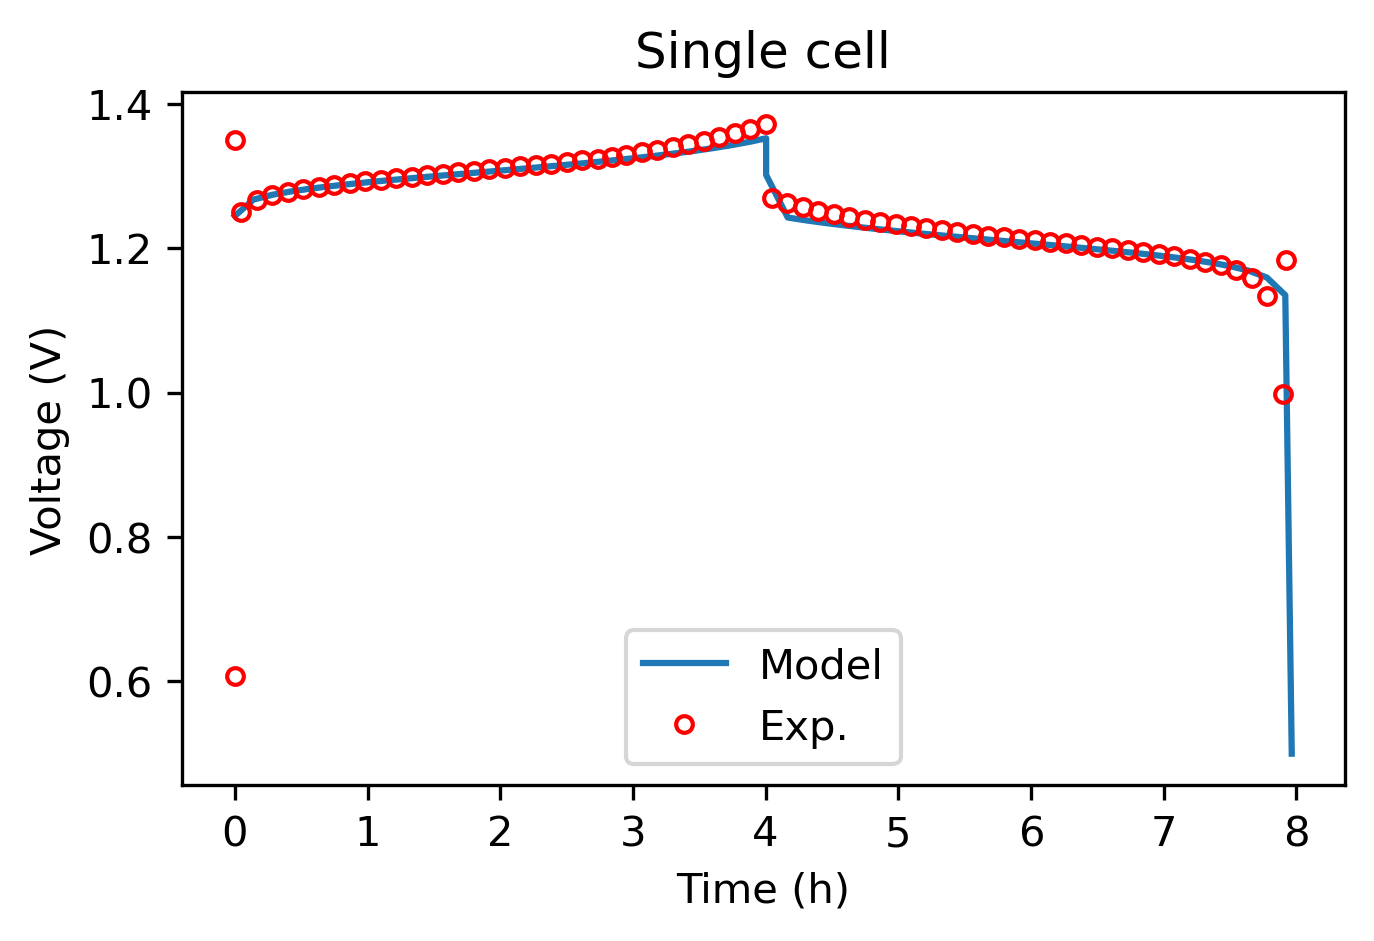

In [4]:
fname = PP0.Experiment.split('\\')[-1]
Exp_data_file = WorkDir + os.sep + fname
Exp_data = pd.read_excel(Exp_data_file)
Exp_data_c1=Exp_data[Exp_data['Cycle_Index']==1]

#%% Plot the comparison between the model prediction and experiment data
plt.figure(figsize=(5, 3),dpi=300)
plt.plot(Re0['Potentials']['Time_s']/3600, Re0['Potentials']['Ec_V'] , label=f'Model',markersize=1)
plt.plot(
    Exp_data_c1['Test_Time(s)'][::7]/3600,  
    Exp_data_c1['Voltage(V)'][::7], 
    'ro', 
    label='Exp.', 
    markerfacecolor='none', 
    markersize=4  
)
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.title('Single cell')

### 3. Scale up this cell, and construct a Zn/I flow battery system
#### 3.1. The system has 60 cells. Each cell is 0.25 x 0.25 m active area

In [5]:
PP1 = copy.deepcopy(PP0)
PP1.BatteryMode = 'power'
PP1.StartTime = 0
PP1.EndTime = 1
PP1.TimeStep = 1
PP1.RefineTimePoints = 1
PP1.Display = 'no'
PP1.DisplayCurrentSearch = 'yes'
PP1.DisplayCurrentSearchIteration = 'no'
PP1.SearchCurrentConvergeTolerance = 1e-3
PP1.CellNumber = 60 # number of cells in the system. The cells are serial connected
PP1.ElectrodeHeight = 0.25 #m
PP1.ElectrodeWidth = 0.25 #m
PP1.CathodeTankVolume = 6e-3 #m3
PP1.AnodeTankVolume = 4e-3 #m3
PP1.CathodePumpRate = 2e-6 #m3/s
PP1.AnodePumpRate = 2e-6 #m3/s
PP1.SearchCurrentMinimum = 0.001
PP1.SearchCurrentMaximum = 200 #the max allowed current of the system

#### 3.2. Construct the system to a 3kW rated power, and 10kWh capacity system

In [6]:
PP1.InitialStatus = -1 #discharge
PP1.DisplayCurrentSearch = 'no'
hours=[0]
currents=[]
vs=[]
shunts=[]
pumps=[]
socs=np.linspace(0.9, 0.1, 51) #the system works between 10% and 90% SOC
C40 = PP1.CathodeReductant1InitialConcentrationInCathode
C50 = PP1.CathodeOxidant1InitialConcentrationInCathode
PP1.Power = 3000 #w
print("Discharging ... ")
for i in tqdm(range(len(socs))):
    PP1.SOC = socs[i]
    C450 = C40/3 + C50
    C4i = (1 - PP1.SOC)*C450*3
    C5i = PP1.SOC*C450
    PP1.CathodeReductant1InitialConcentrationInCathode = C4i
    PP1.CathodeOxidant1InitialConcentrationInCathode = C5i
    idc,vdc,psldc,ppldc,Re1dc,ppdc=searchCurrent(PP1)
    currents.append(idc)
    if i==0:
        hours.append(1)
    elif i<len(socs)-1:
        hours.append(currents[-2]/currents[-1]*hours[-1])
    vs.append(vdc)
    shunts.append(psldc)
    pumps.append(ppldc)

hourss=np.copy(hours)
for i in range(len(hours)):
    hourss[i]=np.sum(hours[:i+1])
hours=np.array(hours)
hours=3.3333/hourss[-1]*hours

hourss=np.copy(hours)
for i in range(len(hours)):
    hourss[i]=np.sum(hours[:i+1])

PP1.InitialStatus = 1 #charge
hours_charge=[0]
currents_charge=[]
vs_charge=[]
shunts_charge=[]
pumps_charge=[]
socs_charge=np.linspace(0.1, 0.9, 51) 
print("Charging ... ")
for i in tqdm(range(len(socs_charge))):
    PP1.SOC = socs_charge[i]
    C450 = C40/3 + C50
    C4i = (1 - PP1.SOC)*C450*3
    C5i = PP1.SOC*C450
    PP1.CathodeReductant1InitialConcentrationInCathode = C4i
    PP1.CathodeOxidant1InitialConcentrationInCathode = C5i
    ic,vc,pslc,pplc, Re1c, ppc = searchCurrent(PP1)
    currents_charge.append(ic)
    if i==0:
        hours_charge.append(currents[1]/ic*hours[2])
    elif i<len(socs_charge)-1:
        hours_charge.append(currents_charge[-2]/currents_charge[-1]*hours_charge[-1])
    vs_charge.append(vc)
    shunts_charge.append(pslc)
    pumps_charge.append(pplc)


hourss_charge=np.copy(hours_charge)
for i in range(len(hours_charge)):
    hourss_charge[i]=np.sum(hours_charge[:i+1])
    
soc_rate=[]
for i in range(len(currents)-1):
    soc_rate.append((-socs[i+1]+socs[i])/currents[i]/hours[i+1])
    #print('discharge',soc_rate[-1],' (SOC/A/hr)')
    
for i in range(len(currents_charge)-1):
    soc_rate.append((socs_charge[i+1]-socs_charge[i])/currents_charge[i]/hours_charge[i+1])
    #print('charge',soc_rate[-1],' (SOC/A/hr)')
    
avg_soc_rate=np.mean(np.array(soc_rate))
print('average SOC rate: ',avg_soc_rate,' (SOC/A/hr)')

Discharging ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:23<00:00,  2.16it/s]


Charging ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:27<00:00,  1.86it/s]

average SOC rate:  0.0045447292310364  (SOC/A/hr)


#### 3.3. Show the cell performance at the rated power.

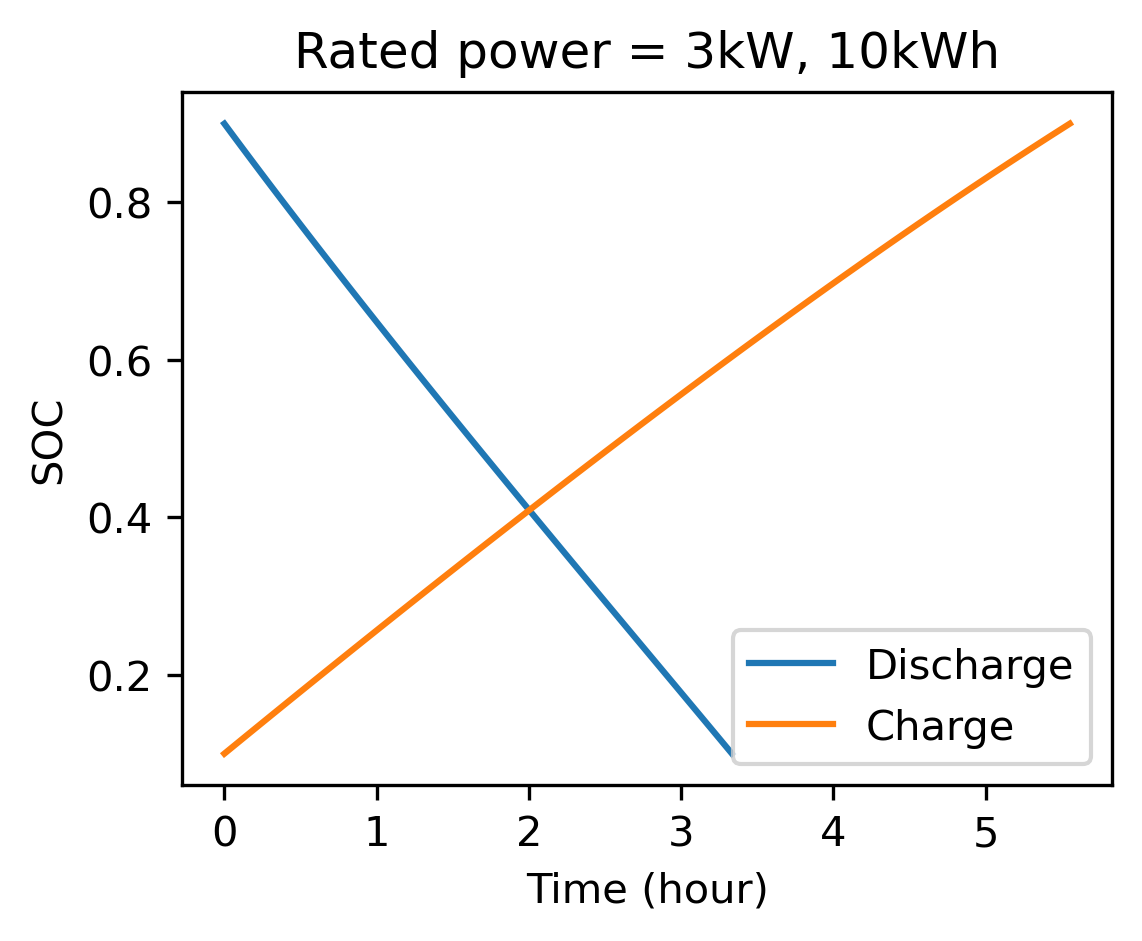

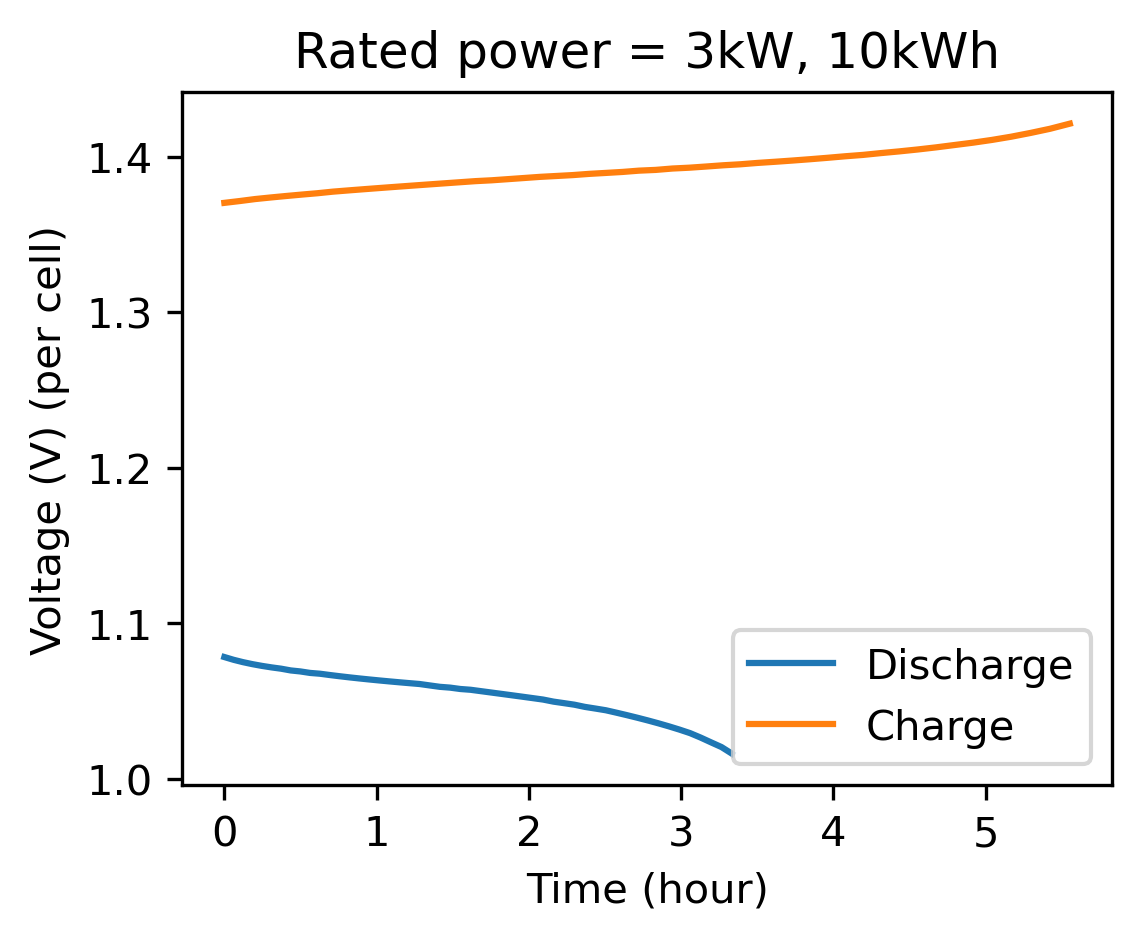

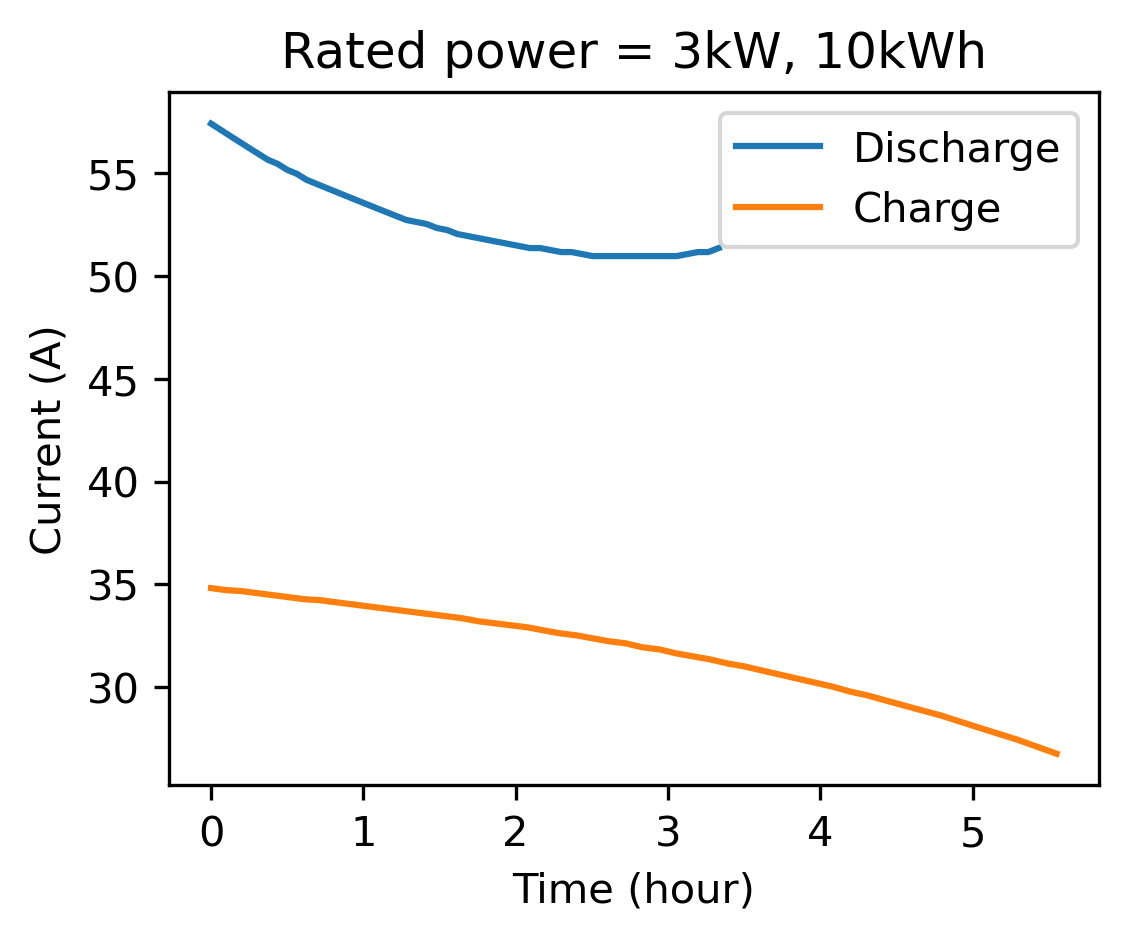

In [7]:
#%% Plot the SOC at the rated power
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(hourss, socs , label=f'Discharge',markersize=1)
plt.plot(hourss_charge, socs_charge , label=f'Charge',markersize=1)
plt.xlabel('Time (hour)')
plt.ylabel('SOC')
plt.legend()
plt.title('Rated power = 3kW, 10kWh')
plt.show()
#%% Plot the voltage at the rated power
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(hourss, vs , label=f'Discharge',markersize=1)
plt.plot(hourss_charge, vs_charge , label=f'Charge',markersize=1)
plt.xlabel('Time (hour)')
plt.ylabel('Voltage (V) (per cell)')
plt.legend()
plt.title('Rated power = 3kW, 10kWh')
plt.show()

#%% Plot the current at the rated power
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(hourss, currents , label=f'Discharge',markersize=1)
plt.plot(hourss_charge, currents_charge , label=f'Charge',markersize=1)
plt.xlabel('Time (hour)')
plt.ylabel('Current (A)')
plt.legend()
plt.title('Rated power = 3kW, 10kWh')
plt.show()

### 4. Operate the system for a load in duty cycle
#### 4.1. Load in the one-week duty cycle. Making sure the charge power higher than the possible maximum pump power (500 W in this example), otherwise the system cannot operate at charging state.

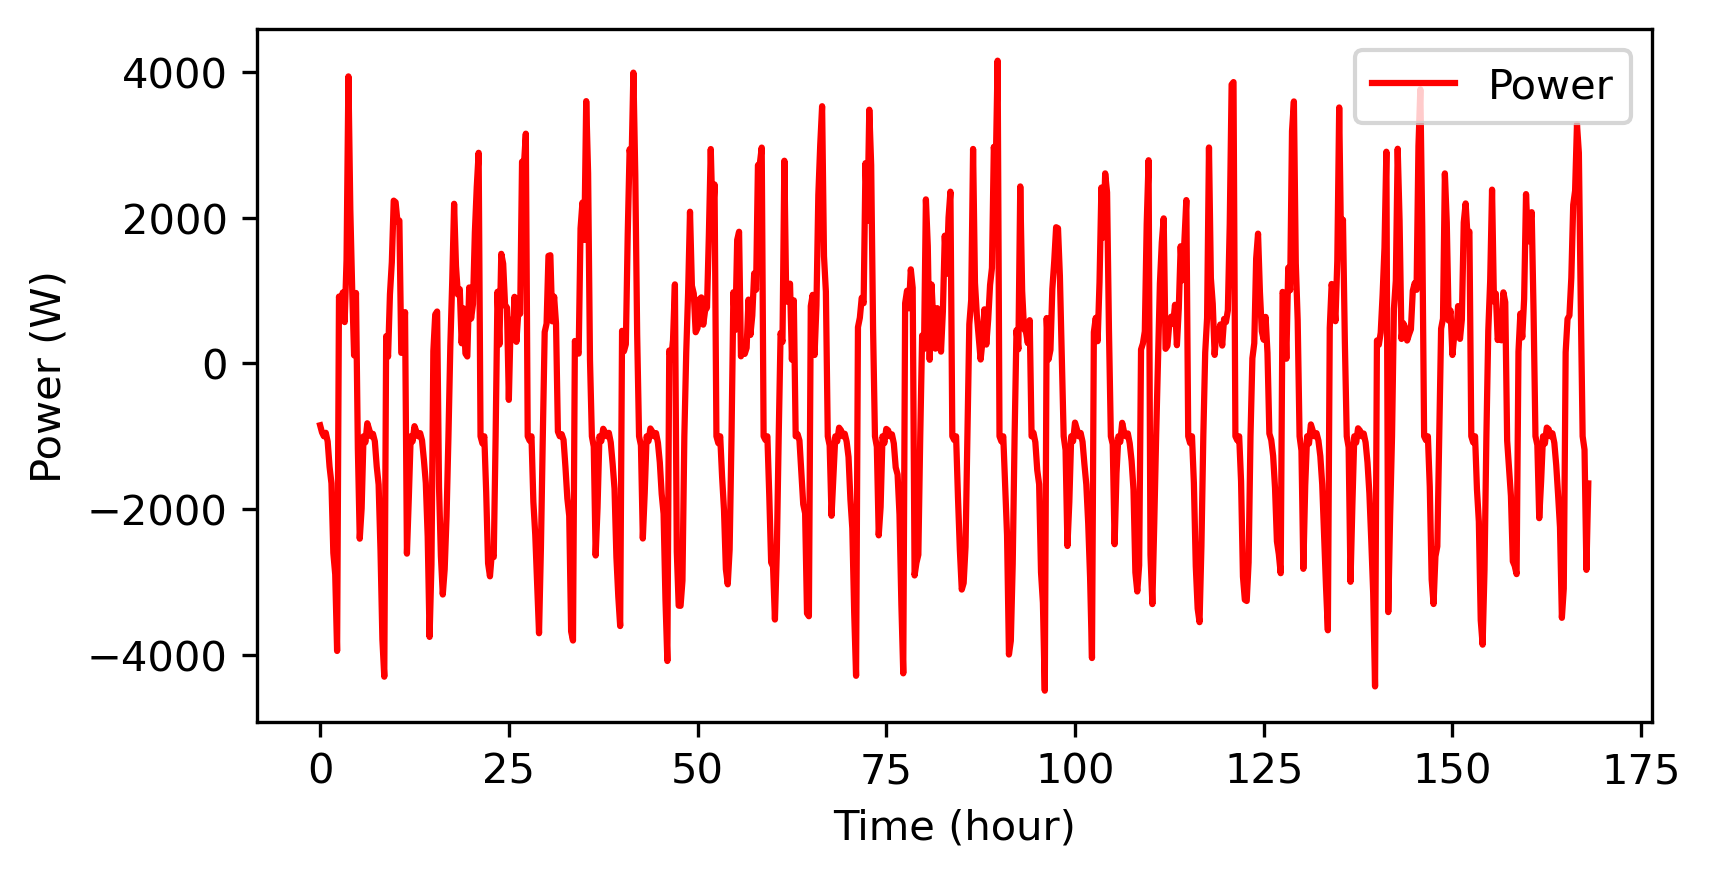

In [8]:
power_test = pd.read_excel(WorkDir + os.sep + 'system_duty_cycles_test.xlsx')
syn_power=np.array(power_test['PowerTest'])
syn_time=np.array(power_test['Hour'])
syn_power[(syn_power[:]<0) & (syn_power[:]>-500)]=-500
syn_power[(syn_power[:]>0) & (syn_power[:]<50)]=50
#%% Plot the loaded duty cycle
plt.figure(figsize=(6, 3),dpi=300)
plt.plot(syn_time, syn_power , label=f'Power',markersize=1,color='red')
plt.xlabel('Time (hour)')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

#### 4.2. Run the model for the load in one-week duty cycle. No degradation

In [9]:
dt=0.25 #hours (time step)
PP1.DisplayCurrentSearch = 'no'
syn_socs=[0.2]
syn_vs=[]
syn_shunts=[]
syn_pumps=[]
syn_currents=[]
syn_hourss0=[0]
print("The system is operating for the load in duty cycle ... ")
for i in tqdm(range((len(syn_time)-1)*int(0.25/dt))):
    ii=int(i*dt/0.25)
    PP1.Power=abs(syn_power[ii])
    #print("{:<10.2f}(hours) {:<5} {:<10.2f}(W) {:<10.2f}(SOC)".format(i*dt, ii, syn_power[ii], syn_socs[-1]))
    if syn_power[ii]>0:
        PP1.InitialStatus = -1 #discharge
    else:
        PP1.InitialStatus = 1 #charge
    PP1.SOC=syn_socs[-1]
    C450 = C40/3 + C50
    C4i = (1 - PP1.SOC)*C450*3
    C5i = PP1.SOC*C450
    PP1.CathodeReductant1InitialConcentrationInCathode = C4i
    PP1.CathodeOxidant1InitialConcentrationInCathode = C5i
    if (syn_socs[-1]<=0.1 and PP1.InitialStatus ==-1) or (syn_socs[-1]>=0.9 and PP1.InitialStatus ==1):
        idc=0
        vdc=0
        psldc=0
        ppldc=0
    else:
        idc,vdc,psldc,ppldc,Re1dc,ppdc=searchCurrent(PP1)
    currents_charge.append(idc)
    if PP1.InitialStatus== -1 : #discharge
        syn_socs.append(syn_socs[-1]-avg_soc_rate*dt*idc)
    else:
        syn_socs.append(syn_socs[-1]+avg_soc_rate*dt*idc)
    syn_vs.append(vdc)
    syn_shunts.append(psldc)
    syn_pumps.append(ppldc)
    if PP1.InitialStatus== -1: 
        syn_currents.append(idc)
    else:
        syn_currents.append(-idc)
    syn_hourss0.append(i*dt)

The system is operating for the load in duty cycle ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 672/672 [06:20<00:00,  1.77it/s]


#### 4.3. Show the voltage, current, and SOC of the system for the load in one-week duty cycle

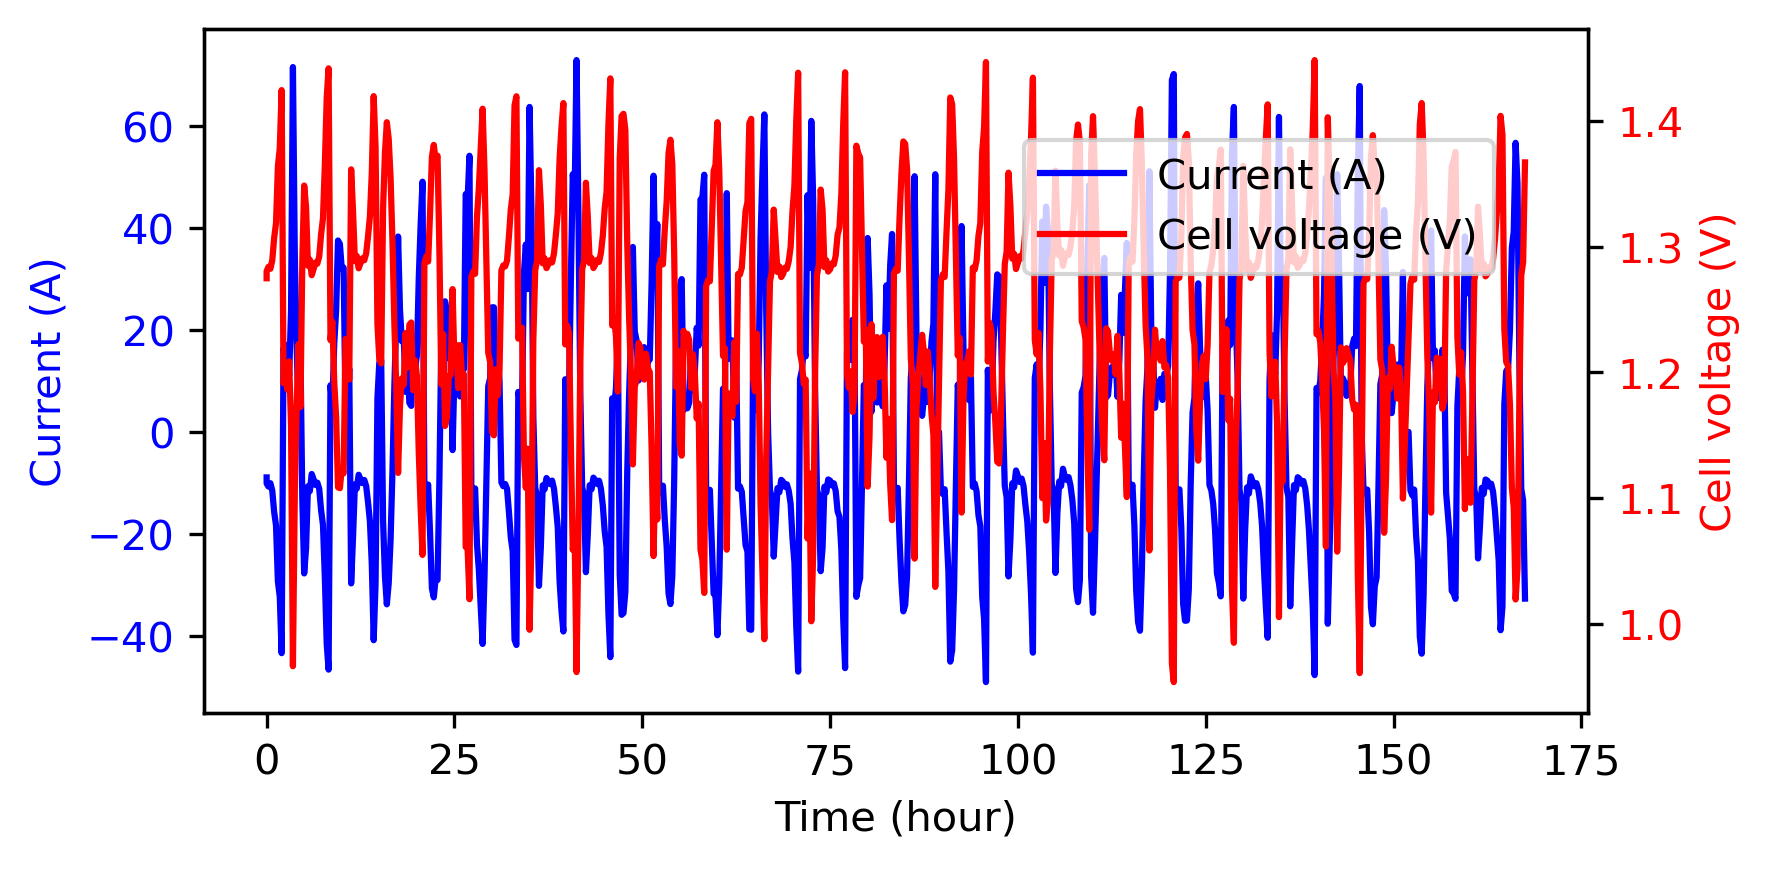

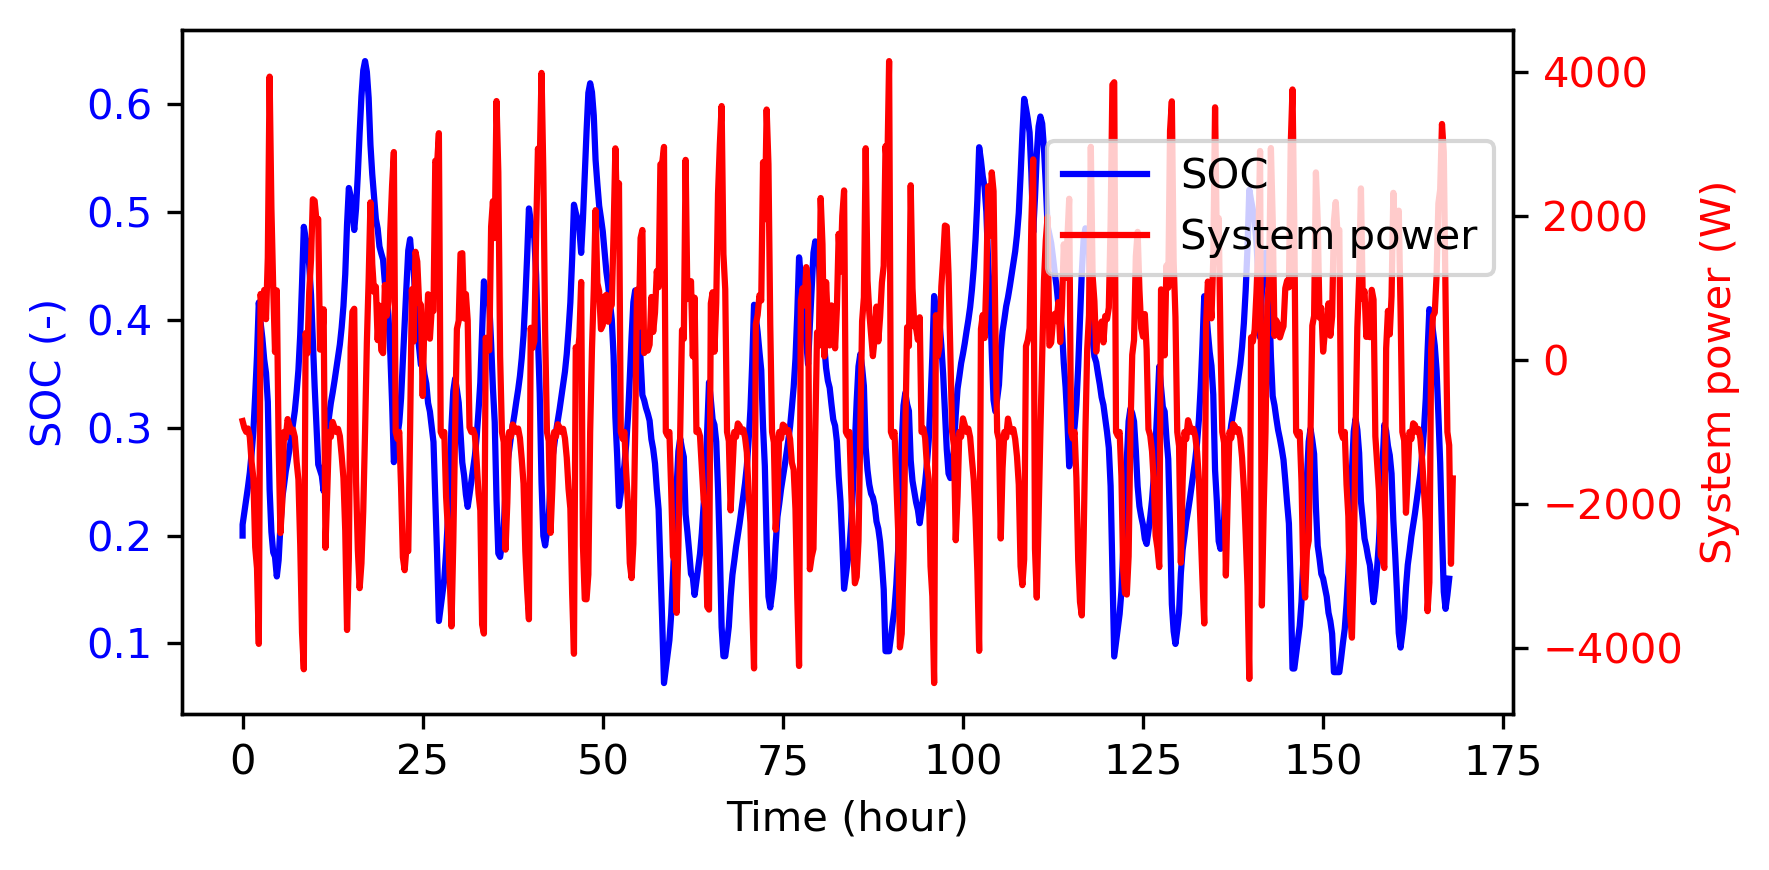

In [12]:
syn_hourss=np.array(syn_hourss0[:-1])
syn_vs=np.array(syn_vs)
syn_hourss_non_zero = syn_hourss[syn_vs[:]>0]
syn_vs_non_zero = syn_vs[syn_vs[:]>0]

#%% Plot the current and voltage on the same figure
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)
# Plot the current (A) data
ax1.plot(syn_hourss[:], syn_currents, 'b-', label='Current (A)', markersize=1)
ax1.set_xlabel('Time (hour)')
ax1.set_ylabel('Current (A)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
# Create the secondary y-axis and plot the cell voltage data
ax2 = ax1.twinx()
ax2.plot(syn_hourss_non_zero, syn_vs_non_zero, 'r-', label='Cell voltage (V)', markersize=1)
ax2.set_ylabel('Cell voltage (V)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Add legends for both plots
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
# Show the combined figure with different axes
plt.show()

#%% Plot the SOC and system power on the same figure
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)
# Plot the SOC data
ax1.plot(syn_hourss, syn_socs[:-1], 'b-', label='SOC', markersize=1)
ax1.set_xlabel('Time (hour)')
ax1.set_ylabel('SOC (-)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
# Create the secondary y-axis and plot the system power data
ax2 = ax1.twinx()
ax2.plot(syn_time, syn_power, 'r-', label='System power', markersize=1)
ax2.set_ylabel('System power (W)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Add legends for both plots
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
# Show the combined figure with different axes
plt.show()

### 5. Generate synthetic system data for a load in one-week duty cycle. With degradation
#### 5.1 Reload in the cell metadata, and set the system capacity as 3kW, 10kWh. Use the results got from the code cells above, in case the user did not run all the code cells above. (Users can directly run the code cell from here, without running the code cells above.)

In [13]:
WorkDir = os.getcwd() +  os.sep +'data'
SDPFName = 'SDPF_ZIB_V5.xlsx'
SDPFPath = WorkDir + os.sep + SDPFName
PP0 = BatteryParameter(SDPFPath)
PP1 = copy.deepcopy(PP0)
PP1.BatteryMode = 'power'
PP1.StartTime = 0
PP1.EndTime = 1
PP1.TimeStep = 1
PP1.RefineTimePoints = 1
PP1.Display = 'no'
PP1.DisplayCurrentSearch = 'no'
PP1.DisplayCurrentSearchIteration = 'no'
PP1.SearchCurrentConvergeTolerance = 1e-3
PP1.CellNumber = 60 # number of cells in the system. The cells are serial connected
PP1.ElectrodeHeight = 0.25 #m
PP1.ElectrodeWidth = 0.25 #m
PP1.CathodeTankVolume = 6e-3 #m3
PP1.AnodeTankVolume = 4e-3 #m3
PP1.CathodePumpRate = 2e-6 #m3/s
PP1.AnodePumpRate = 2e-6 #m3/s
PP1.Power = 30 #w user can try different power
PP1.SearchCurrentMinimum = 0.001
PP1.SearchCurrentMaximum = 200 #the max allowed current of the system
PP1.SOC = 0.6
C40 = copy.copy(PP1.CathodeReductant1InitialConcentrationInCathode)
C50 = copy.copy(PP1.CathodeOxidant1InitialConcentrationInCathode)
C300 = copy.copy(PP1.AnodeReductant1InitialConcentrationInAnode)
C200 = copy.copy(PP1.AnodeOxidant1InitialConcentrationInAnode)

Mcond=copy.copy(PP1.MembraneElectronicConductivity)

power_test = pd.read_excel(WorkDir + os.sep + 'system_duty_cycles_test.xlsx')
syn_power=np.array(power_test['PowerTest'])
syn_time=np.array(power_test['Hour'])
syn_power[(syn_power[:]<0) & (syn_power[:]>-500)]=-500
syn_power[(syn_power[:]>0) & (syn_power[:]<50)]=50

avg_soc_rate=0.00495263 # this is from the results got in the code cell above.

#%% real calculation
dt=0.05 #hours (time step)
syn_socs=[0.2]
syn_vs=[]
syn_shunts=[]
syn_pumps=[]
syn_currents=[]
syn_hourss0=[0]
init_avg_soc_rate=copy.copy(avg_soc_rate)

syn_C20=[]
syn_Mcond=[]
syn_soc_rate=[]
syn_power2=[]
print("Generating the system synthetic performance data for a load in one-week duty cycle ... ; the active material concnetration decreases 1% per day; the membrane conductivity decreases 1% per day.")
for i in tqdm(range((len(syn_time)-1)*int(0.25/dt))):
    ii=int(i*dt/0.25)
    PP1.Power=abs(syn_power[ii])
    time_day=np.floor(syn_time[ii]/24)

    PP1.AnodeOxidant1InitialConcentrationInAnode=C200*0.99**time_day
    PP1.MembraneElectronicConductivity=Mcond*0.99**time_day
    avg_soc_rate_mod=init_avg_soc_rate

    syn_C20.append(PP1.AnodeOxidant1InitialConcentrationInAnode)
    syn_Mcond.append(PP1.MembraneElectronicConductivity)
    syn_soc_rate.append(avg_soc_rate_mod)
    syn_power2.append(syn_power[ii])
    #print("{:<10.2f}(hours) {:<5} {:<10.2f}(W) {:<10.2f}(SOC) {:<10.2f}(C40) {:<10.2f}(C50) {:<10.2f}(C20) {:<10.4f}(Mcond) {:<10.4f}(SOC rate)".format(i*dt, ii, syn_power[ii], syn_socs[-1],syn_C40[-1],syn_C50[-1],syn_C20[-1],syn_Mcond[-1],syn_soc_rate[-1]))
    
    if syn_power[ii]>0:
        PP1.InitialStatus = -1 #discharge
    else:
        PP1.InitialStatus = 1 #charge
    PP1.SOC=syn_socs[-1]
    C450 = C40/3 + C50
    C4i = (1 - PP1.SOC)*C450*3
    C5i = PP1.SOC*C450
    PP1.CathodeReductant1InitialConcentrationInCathode = C4i
    PP1.CathodeOxidant1InitialConcentrationInCathode = C5i
    if (syn_socs[-1]<=0.1 and PP1.InitialStatus ==-1) or (syn_socs[-1]>=0.9 and PP1.InitialStatus ==1):
        idc=0
        vdc=0
        psldc=0
        ppldc=0
    else:
        idc,vdc,psldc,ppldc,Re1dc,ppdc=searchCurrent(PP1)

    if PP1.InitialStatus== -1 : #discharge
        syn_socs.append(syn_socs[-1]-avg_soc_rate_mod*dt*idc)
    else:
        syn_socs.append(syn_socs[-1]+avg_soc_rate_mod*dt*idc)
    syn_vs.append(vdc)
    syn_shunts.append(psldc)
    syn_pumps.append(ppldc)
    if PP1.InitialStatus== -1: 
        syn_currents.append(idc)
    else:
        syn_currents.append(-idc)
    syn_hourss0.append(i*dt)

Generating the system synthetic performance data for a load in one-week duty cycle ... ; the active material concnetration decreases 1% per day; the membrane conductivity decreases 1% per day.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3360/3360 [32:05<00:00,  1.74it/s]


#### 5.2. Show the results for the system runing at the load in one-week duty cycle

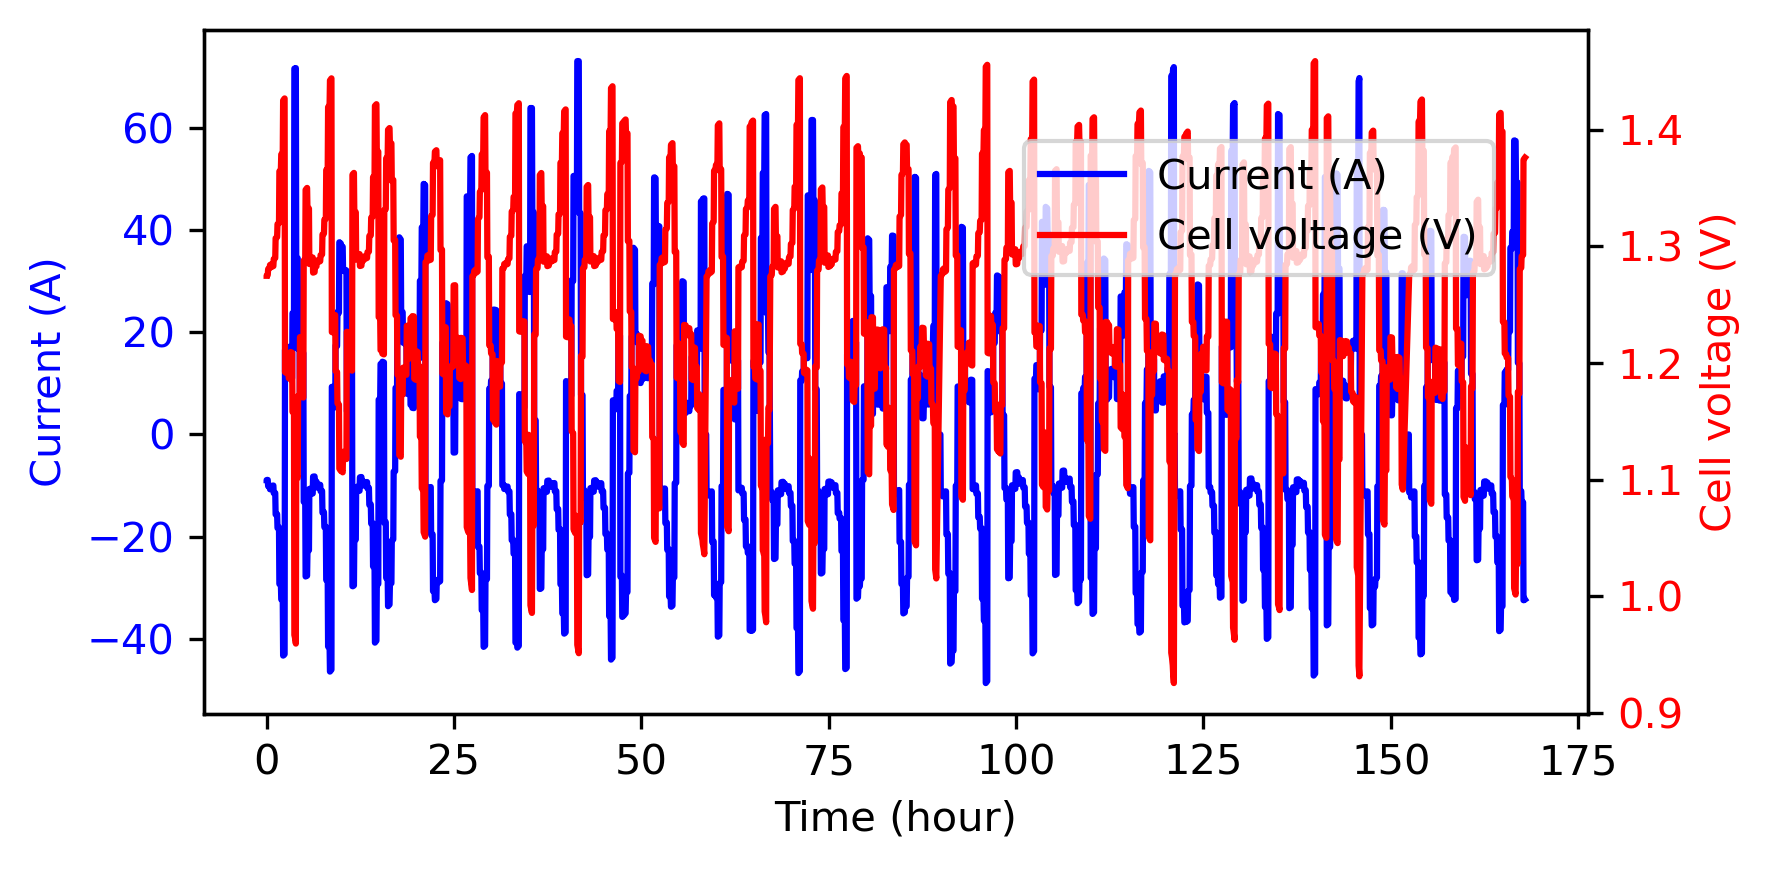

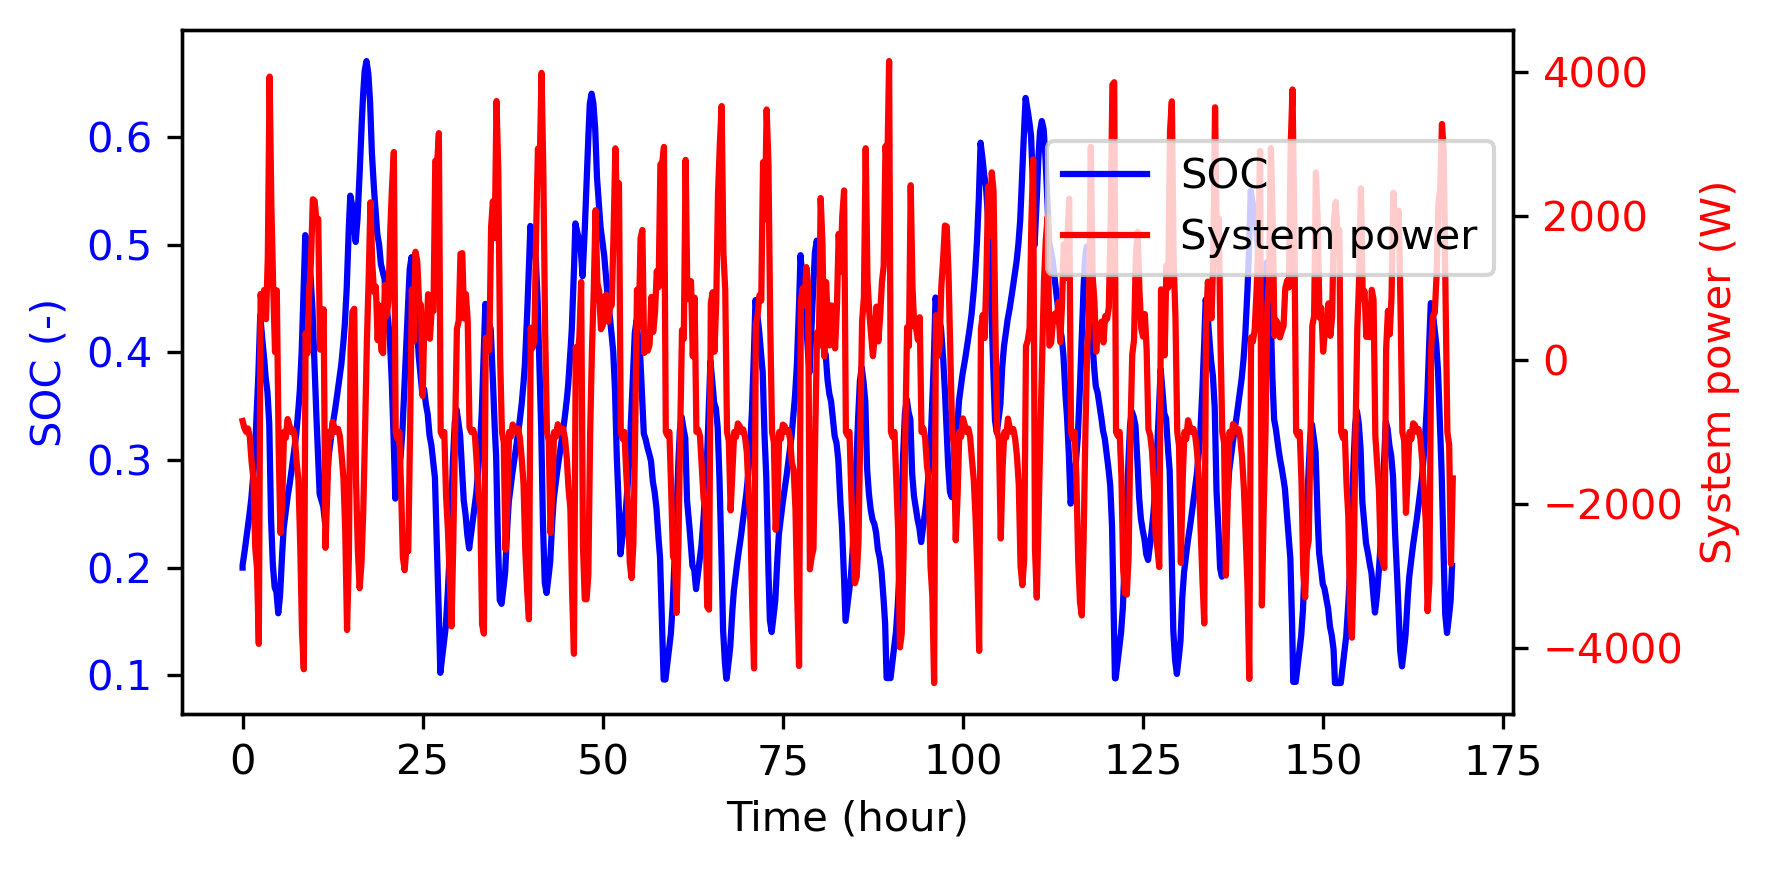

In [14]:
syn_hourss=np.array(syn_hourss0[:-1])
syn_vs=np.array(syn_vs)
syn_hourss_non_zero = syn_hourss[syn_vs[:]>0]
syn_vs_non_zero = syn_vs[syn_vs[:]>0]
#%% Plot the current and voltage on the same figure
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)
# Plot the current (A) data
ax1.plot(syn_hourss[:], syn_currents, 'b-', label='Current (A)', markersize=1)
ax1.set_xlabel('Time (hour)')
ax1.set_ylabel('Current (A)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
# Create the secondary y-axis and plot the cell voltage data
ax2 = ax1.twinx()
ax2.plot(syn_hourss_non_zero, syn_vs_non_zero, 'r-', label='Cell voltage (V)', markersize=1)
ax2.set_ylabel('Cell voltage (V)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Add legends for both plots
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
# Show the combined figure with different axes
plt.show()
#%% Plot the SOC and system power on the same figure
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)
# Plot the SOC data
ax1.plot(syn_hourss, syn_socs[:-1], 'b-', label='SOC', markersize=1)
ax1.set_xlabel('Time (hour)')
ax1.set_ylabel('SOC (-)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
# Create the secondary y-axis and plot the system power data
ax2 = ax1.twinx()
ax2.plot(syn_time, syn_power, 'r-', label='System power', markersize=1)
ax2.set_ylabel('System power (W)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Add legends for both plots
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
# Show the combined figure with different axes
plt.show()

#### 5.3. Save the results to csv files

In [15]:
syn_data_all=np.column_stack([syn_hourss,syn_currents,syn_vs,syn_socs[:-1],syn_pumps,syn_shunts,syn_power2])
df = pd.DataFrame(syn_data_all, columns=['Time(h)','current(A)', 'voltage(V)', 'SOC','Power_pump(W)','Power_shunt(W)','Power_sys(W)' ])
 
# Save DataFrame to CSV
savefile=WorkDir + os.sep + 'one_week_syn_data_2_deg.csv'
df.to_csv(savefile, index=False)

print("Array saved to",savefile)

syn_data_all=np.column_stack([syn_time,syn_power])
df = pd.DataFrame(syn_data_all, columns=['Time(h)', 'Power(W)'])
savefile=WorkDir + os.sep + 'one_week_syn_power_input_data_2_deg.csv'
df.to_csv(savefile, index=False)
print("Array saved to",savefile)

syn_data_all=np.column_stack([syn_hourss,syn_C20,syn_Mcond,syn_soc_rate])
df = pd.DataFrame(syn_data_all, columns=['Time(h)','C20(mol/m3)', 'MembraneCond(S/m)','SOCRate(SOC/A/h)' ])
savefile=WorkDir + os.sep + 'one_week_syn_degradation_data_2_deg.csv'
df.to_csv(savefile, index=False)
print("Array saved to",savefile)

Array saved to D:\ROVI\OCED\demo\EZBattery-new_examples_debug10062025\EZBattery-new_examples\data\one_week_syn_data_2_deg.csv
Array saved to D:\ROVI\OCED\demo\EZBattery-new_examples_debug10062025\EZBattery-new_examples\data\one_week_syn_power_input_data_2_deg.csv
Array saved to D:\ROVI\OCED\demo\EZBattery-new_examples_debug10062025\EZBattery-new_examples\data\one_week_syn_degradation_data_2_deg.csv


### 6. Diagnose the system (streaming) data
### Identify the properties' degradations
#### 6.1. Load in the system streming data

In [16]:
loadfile=WorkDir + os.sep + 'one_week_syn_data_2_deg.csv'
one_week_syn_data = pd.read_csv(loadfile)

#### 6.2. Define the loss function and optimization fucntion
#### The diagnosis is based on Differential Evolution approach. It can run in multi-thread mode to accelerate the speed. However, in Jupyter Notebook, the multi-thread feature may not work approperiately. Therefore, the example here only use single thread as a demo. For testing on multi-thread, please directly run the demo code "Zn_system_diagnose_demo.py". 
#### There are several parameters in the Differential Evolution approach may impact the runing speed and the accuracy. The users can adjust them to balance the speed and accuracy.
##### In "loss_function", interval=50 is the interval between the sampling points to caculate the difference between model prediction and true data. larger value -> faster but lower accuracy
##### In "differential_evolution_optimize", popsize=120 is the number of simulation cases in each iteration. larger value -> slower but higher accuracy
##### In "differential_evolution_optimize", workers=1 is the number of threads running together. Make sure it is no more than the avalaible CPU threads. larger value -> faster 

In [17]:
def loss_function(x, param, socs, currents, true_power):
    C40 = 3000 
    C50 = 0

    param.AnodeOxidant1InitialConcentrationInAnode = x[0]
    param.MembraneElectronicConductivity = x[1]

    test_power = []
    true_power_cut = []
    interval=50
    for i in range(1, len(socs), interval):
        if abs(currents[i]) > 1e-8:
            param.SOC = socs[i]
            param.Current = abs(currents[i])
            C450 = C40 / 3 + C50
            C4i = (1 - param.SOC) * C450 * 3
            C5i = param.SOC * C450
            param.CathodeReductant1InitialConcentrationInCathode = C4i
            param.CathodeOxidant1InitialConcentrationInCathode = C5i
            if currents[i] > 0: param.InitialStatus = -1  # discharge
            if currents[i] < 0: param.InitialStatus = 1   # charge
            power, v, spl, ppl, Re, PPC = systemPower(param)
            if currents[i] < 0: power = -power
            test_power.append(power)
            true_power_cut.append(true_power[i])

    true_power_cut = np.array(true_power_cut)
    test_power = np.array(test_power)
    loss = np.sqrt(np.mean((true_power_cut - test_power) ** 2))
    #print('loss', loss, 'x', x[0], x[1], flush=True)
    return loss

def callback(xk, convergence):
    print(f"Current best solution: {xk}, Convergence: {convergence}")
    #print("Flushing output...")
    sys.stdout.flush()

def differential_evolution_optimize(loss_function, bounds, args):
    res = optimize.differential_evolution(
        loss_function,
        bounds,
        args=args,
        maxiter=25,
        popsize=60,
        workers=1,
        disp=True,
        callback=callback
    )
    return res

#### 6.3. Run the diagnosis framework for the load in one-week system streaming data. The results are saved in file diagnosis_results_2_deg_test.csv. This diagnosis process may take around 2 hours. 

In [18]:
WorkDir = os.getcwd() +  os.sep +'data'
SDPFName = 'SDPF_ZIB_V5.xlsx'
SDPFPath = WorkDir + os.sep + SDPFName
PP0 = BatteryParameter(SDPFPath)
PP1 = copy.deepcopy(PP0)
PP1.BatteryMode = 'power'
PP1.StartTime = 0
PP1.EndTime = 1
PP1.TimeStep = 1
PP1.RefineTimePoints = 1
PP1.Display = 'no'
PP1.DisplayCurrentSearch = 'no'
PP1.DisplayCurrentSearchIteration = 'no'
PP1.SearchCurrentConvergeTolerance = 1e-3
PP1.CellNumber = 60
PP1.ElectrodeHeight = 0.25
PP1.ElectrodeWidth = 0.25
PP1.CathodeTankVolume = 6e-3
PP1.AnodeTankVolume = 4e-3
PP1.CathodePumpRate = 2e-6
PP1.AnodePumpRate = 2e-6
PP1.Power = 30
PP1.SearchCurrentMinimum = 0.001
PP1.SearchCurrentMaximum = 200


result_file=WorkDir + os.sep + 'diagnosis_results_2_deg_test.csv'
result_out=open(result_file,'w')
bounds = [(300, 450), (0.5, 1.5)]

for i in tqdm(range(7)):
    true_batch = one_week_syn_data[np.floor(one_week_syn_data['Time(h)'] / 24) == i]
    print('diagnose day #', i, 'size of data', true_batch.shape, flush=True)

    res = dict()
    PP2 = copy.deepcopy(PP1)
    #print(true_batch)

    result = differential_evolution_optimize(
        loss_function, bounds, (PP2, np.array(true_batch['SOC']), np.array(true_batch['current(A)']), np.array(true_batch['Power_sys(W)']))
    )
    print('results x:', result['x'][0], result['x'][1],file=result_out,flush=True)
    bounds = [(result['x'][0] * 0.85, result['x'][0] * 1.15), (result['x'][1] * 0.85, result['x'][1] * 1.15)]
result_out.close()

  0%|                                                                                                                                                    | 0/7 [00:00<?, ?it/s]

diagnose day # 0 size of data (481, 7)
differential_evolution step 1: f(x)= 0.862844
Current best solution: [412.2722742    0.62743598], Convergence: 0.015123179681788472
differential_evolution step 2: f(x)= 0.720206
Current best solution: [412.2722742    0.62854295], Convergence: 0.01257225471849835
differential_evolution step 3: f(x)= 0.670445
Current best solution: [397.93907931   0.6294557 ], Convergence: 0.009035831795100807
differential_evolution step 4: f(x)= 0.637416
Current best solution: [410.74335986   0.63318138], Convergence: 0.009185926206238685
differential_evolution step 5: f(x)= 0.58914
Current best solution: [400.94539845   0.62999035], Convergence: 0.007352251285054439
differential_evolution step 6: f(x)= 0.543191
Current best solution: [406.47424312   0.63210462], Convergence: 0.010704783557996669
differential_evolution step 7: f(x)= 0.514641
Current best solution: [407.97383164   0.63088988], Convergence: 0.017952663340037263
differential_evolution step 8: f(x)= 0.

 14%|███████████████████▌                                                                                                                     | 1/7 [13:35<1:21:31, 815.28s/it]

diagnose day # 1 size of data (480, 7)
differential_evolution step 1: f(x)= 1.08613
Current best solution: [389.32744885   0.62417   ], Convergence: 0.011974770093908387
differential_evolution step 2: f(x)= 1.08613
Current best solution: [389.32744885   0.62417   ], Convergence: 0.012555006707487625
differential_evolution step 3: f(x)= 1.0823
Current best solution: [390.34022283   0.62417   ], Convergence: 0.010713974545771656
differential_evolution step 4: f(x)= 1.02127
Current best solution: [390.12589771   0.62350476], Convergence: 0.012260210092097854
differential_evolution step 5: f(x)= 1.02127
Current best solution: [390.12589771   0.62350476], Convergence: 0.014281968527930155
differential_evolution step 6: f(x)= 1.02127
Current best solution: [390.12589771   0.62350476], Convergence: 0.02515977523276525
differential_evolution step 7: f(x)= 1.02103
Current best solution: [390.08373682   0.62353761], Convergence: 0.03508116788708222
differential_evolution step 8: f(x)= 1.02001
Cu

 29%|███████████████████████████████████████▏                                                                                                 | 2/7 [24:54<1:01:15, 735.13s/it]

diagnose day # 2 size of data (480, 7)
differential_evolution step 1: f(x)= 1.21449
Current best solution: [393.58457212   0.61773679], Convergence: 0.014540301640416866
differential_evolution step 2: f(x)= 1.10226
Current best solution: [378.02795363   0.61817756], Convergence: 0.013548647136415059
differential_evolution step 3: f(x)= 1.07319
Current best solution: [381.49314445   0.61767303], Convergence: 0.0173189343971149
differential_evolution step 4: f(x)= 1.07319
Current best solution: [381.49314445   0.61767303], Convergence: 0.020113260248930814
differential_evolution step 5: f(x)= 1.07319
Current best solution: [381.49314445   0.61767303], Convergence: 0.022969684628423696
differential_evolution step 6: f(x)= 1.07319
Current best solution: [381.49314445   0.61767303], Convergence: 0.03349151529888254
differential_evolution step 7: f(x)= 1.07309
Current best solution: [382.33197778   0.61759597], Convergence: 0.04309529612161045
differential_evolution step 8: f(x)= 1.07304
Cur

 43%|███████████████████████████████████████████████████████████▌                                                                               | 3/7 [34:38<44:25, 666.35s/it]

diagnose day # 3 size of data (480, 7)
differential_evolution step 1: f(x)= 0.635253
Current best solution: [405.13127127   0.60521455], Convergence: 0.016331634650781586
differential_evolution step 2: f(x)= 0.572021
Current best solution: [399.63043487   0.60792896], Convergence: 0.015039042809893296
differential_evolution step 3: f(x)= 0.572021
Current best solution: [399.63043487   0.60792896], Convergence: 0.013327632716089128
differential_evolution step 4: f(x)= 0.572021
Current best solution: [399.63043487   0.60792896], Convergence: 0.013370965590901533
differential_evolution step 5: f(x)= 0.572021
Current best solution: [399.63043487   0.60792896], Convergence: 0.017672514807650492
differential_evolution step 6: f(x)= 0.572021
Current best solution: [399.63043487   0.60792896], Convergence: 0.019094303216488966
differential_evolution step 7: f(x)= 0.571562
Current best solution: [399.77409632   0.60780616], Convergence: 0.033020895351779954
differential_evolution step 8: f(x)= 

 57%|███████████████████████████████████████████████████████████████████████████████▍                                                           | 4/7 [43:04<30:08, 602.95s/it]

diagnose day # 4 size of data (480, 7)
differential_evolution step 1: f(x)= 0.892997
Current best solution: [368.7865969    0.60616331], Convergence: 0.01361490125731062
differential_evolution step 2: f(x)= 0.892997
Current best solution: [368.7865969    0.60616331], Convergence: 0.012172201771706956
differential_evolution step 3: f(x)= 0.5287
Current best solution: [388.68579006   0.60545244], Convergence: 0.010843744236270084
differential_evolution step 4: f(x)= 0.415664
Current best solution: [382.54125916   0.60528478], Convergence: 0.010642771373840867
differential_evolution step 5: f(x)= 0.384504
Current best solution: [384.78376265   0.60508538], Convergence: 0.016345259174419976
differential_evolution step 6: f(x)= 0.367607
Current best solution: [388.12329492   0.60417677], Convergence: 0.019077128509408767
differential_evolution step 7: f(x)= 0.352848
Current best solution: [385.65245539   0.60449472], Convergence: 0.020362616267997055
differential_evolution step 8: f(x)= 0.3

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 5/7 [56:35<22:36, 678.04s/it]

diagnose day # 5 size of data (480, 7)
differential_evolution step 1: f(x)= 1.35889
Current best solution: [338.90798348   0.59649812], Convergence: 0.013917692981241065
differential_evolution step 2: f(x)= 0.933638
Current best solution: [358.54496519   0.59740134], Convergence: 0.01244697229647882
differential_evolution step 3: f(x)= 0.913328
Current best solution: [362.62267506   0.59767744], Convergence: 0.009983744694748746
differential_evolution step 4: f(x)= 0.913328
Current best solution: [362.62267506   0.59767744], Convergence: 0.013635853941699234
differential_evolution step 5: f(x)= 0.913328
Current best solution: [362.62267506   0.59767744], Convergence: 0.014080900698183367
differential_evolution step 6: f(x)= 0.82912
Current best solution: [360.4431103    0.59802177], Convergence: 0.021813405363338704
differential_evolution step 7: f(x)= 0.792426
Current best solution: [361.37396751   0.59861563], Convergence: 0.029238571809480217
differential_evolution step 8: f(x)= 0.7

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [1:11:08<12:24, 744.27s/it]

diagnose day # 6 size of data (479, 7)
differential_evolution step 1: f(x)= 1.61339
Current best solution: [382.55552138   0.59426138], Convergence: 0.01385343472878352
differential_evolution step 2: f(x)= 1.61339
Current best solution: [382.55552138   0.59426138], Convergence: 0.013296037093929782
differential_evolution step 3: f(x)= 1.61339
Current best solution: [382.55552138   0.59426138], Convergence: 0.013787766812960775
differential_evolution step 4: f(x)= 1.35732
Current best solution: [369.89502392   0.5934104 ], Convergence: 0.015157318507847501
differential_evolution step 5: f(x)= 1.35502
Current best solution: [365.01309264   0.59253643], Convergence: 0.015182565503499727
differential_evolution step 6: f(x)= 1.35403
Current best solution: [365.95024432   0.59318046], Convergence: 0.026557952061704828
differential_evolution step 7: f(x)= 1.35403
Current best solution: [365.95024432   0.59318046], Convergence: 0.04317440434635766
differential_evolution step 8: f(x)= 1.34028
C

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [1:23:44<00:00, 717.84s/it]


#### 6.4. Show the results, comprison between the diagnostic results and the true "make up" degradation

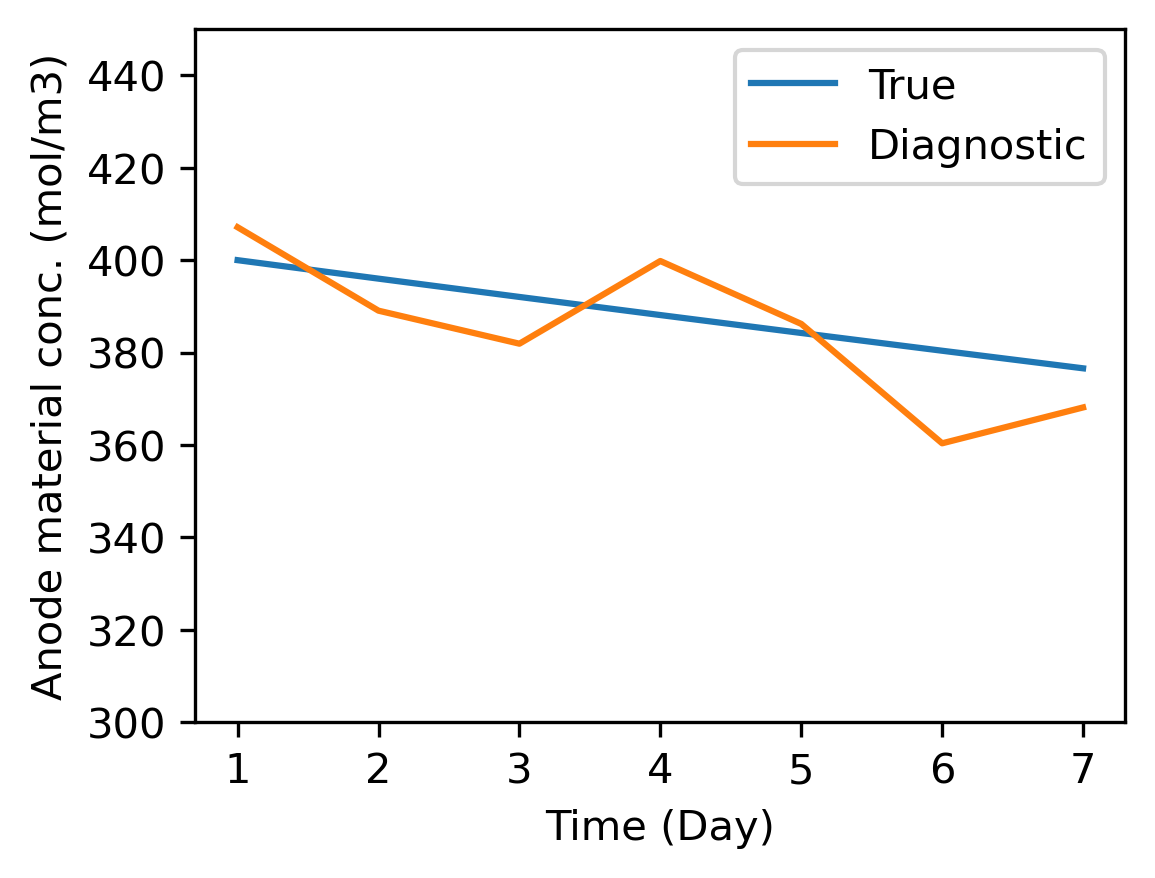

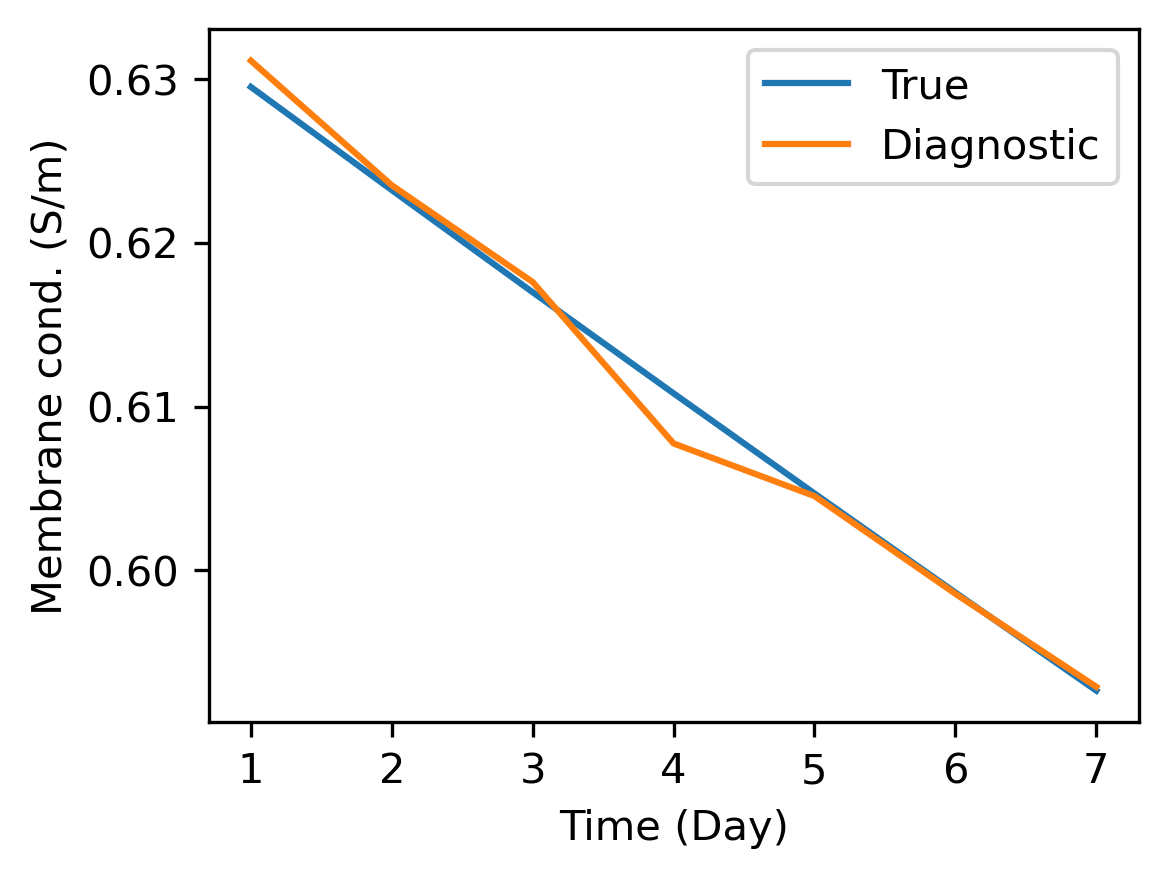

In [19]:
loadfile=WorkDir + os.sep + 'diagnosis_results_2_deg_test.csv'
diag = pd.read_csv(loadfile,sep=' ',header=None)

loadfile=WorkDir + os.sep + 'one_week_syn_degradation_data_2_deg.csv'
one_week_syn_degradation_data = pd.read_csv(loadfile)
#%%
real_deg_1=[]
real_deg_2=[]
points_per_day=len(one_week_syn_degradation_data['C20(mol/m3)'])/7
for day in range(7):
    iprop = int(day * int(points_per_day) + int(points_per_day/2))
    real_deg_1.append(one_week_syn_degradation_data['C20(mol/m3)'][iprop])
    real_deg_2.append(one_week_syn_degradation_data['MembraneCond(S/m)'][iprop])
#%%
days=np.arange(1,8)  


#%%
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(days, real_deg_1 , label=f'True',markersize=1)
plt.plot(days , diag[:][2],label=f'Diagnostic',markersize=1)
plt.xlabel('Time (Day)')
plt.ylabel('Anode material conc. (mol/m3)')
plt.legend()
plt.ylim(300,450)
#plt.title('Rated power = 3kW, 10kWh')
plt.show()

#%%
#%%
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(days, real_deg_2 , label=f'True',markersize=1)
plt.plot(days , diag[:][3],label=f'Diagnostic',markersize=1)
plt.xlabel('Time (Day)')
plt.ylabel('Membrane cond. (S/m)')
plt.legend()
#plt.ylim(300,450)
#plt.title('Rated power = 3kW, 10kWh')
plt.show()

#### 6.5. Estimate the system performance at rated power with diagostic degradation results

In [20]:
results = []
WorkDir = os.getcwd() +  os.sep +'data'
SDPFName = 'SDPF_ZIB_V5.xlsx'
SDPFPath = WorkDir + os.sep + SDPFName
PP0 = BatteryParameter(SDPFPath)
PP1 = copy.deepcopy(PP0)
PP1.BatteryMode = 'power'
PP1.StartTime = 0
PP1.EndTime = 1
PP1.TimeStep = 1
PP1.RefineTimePoints = 1
PP1.Display = 'no'
PP1.DisplayCurrentSearch = 'no'
PP1.DisplayCurrentSearchIteration = 'no'
PP1.SearchCurrentConvergeTolerance = 1e-3
PP1.CellNumber = 60
PP1.ElectrodeHeight = 0.25
PP1.ElectrodeWidth = 0.25
PP1.CathodeTankVolume = 6e-3
PP1.AnodeTankVolume = 4e-3
PP1.CathodePumpRate = 2e-6
PP1.AnodePumpRate = 2e-6
PP1.Power = 30
PP1.SearchCurrentMinimum = 0.001
PP1.SearchCurrentMaximum = 200
dt = 0.05  # hours (time step)

for day in (range(7)):    
    syn_socs = [0.1]
    syn_vs = []
    syn_shunts = []
    syn_pumps = []
    syn_currents = []
    syn_hourss = [0]
    init_avg_soc_rate = copy.copy(one_week_syn_degradation_data['SOCRate(SOC/A/h)'][0])
    syn_C40 = []
    syn_C50 = []
    syn_C20 = []
    syn_Mcond = []
    syn_soc_rate = []
    syn_power2 = []
    PP1.InitialStatus = 1
    print('Day ',day)
    for i in tqdm(range(500)):
        ii = int(i * dt / 0.25)
        PP1.Power = 3000  # abs(syn_power[ii])
        # time_day=np.floor(syn_time[ii]/24)
        C40 = 3000 #one_week_syn_degradation_data['C40(mol/m3)'][iprop]
        C50 = 0  # C500*0.995**time_day
        PP1.AnodeOxidant1InitialConcentrationInAnode = diag[2][day] #one_week_syn_degradation_data['C20(mol/m3)'][iprop]
        PP1.MembraneElectronicConductivity = diag[3][day] #one_week_syn_degradation_data['MembraneCond(S/m)'][iprop]
        avg_soc_rate_mod =  init_avg_soc_rate
        syn_C40.append(C40)
        syn_C50.append(C50)
        syn_C20.append(PP1.AnodeOxidant1InitialConcentrationInAnode)
        syn_Mcond.append(PP1.MembraneElectronicConductivity)
        syn_soc_rate.append(avg_soc_rate_mod)
        syn_power2.append(PP1.Power)

        PP1.SOC = syn_socs[-1]
        C450 = C40 / 3 + C50
        C4i = (1 - PP1.SOC) * C450 * 3
        C5i = PP1.SOC * C450
        PP1.CathodeReductant1InitialConcentrationInCathode = C4i
        PP1.CathodeOxidant1InitialConcentrationInCathode = C5i
        #print(syn_socs[-1], PP1.InitialStatus)
        if (syn_socs[-1] >= 0.9) and (PP1.InitialStatus == 1):
            PP1.InitialStatus = -1

        if (syn_socs[-1] <= 0.1) and (PP1.InitialStatus == -1):
            break

        idc, vdc, psldc, ppldc, Re1dc, ppdc = searchCurrent(PP1)

        if PP1.InitialStatus == -1:  # discharge
            syn_socs.append(syn_socs[-1] - avg_soc_rate_mod * dt * idc)
        else:
            syn_socs.append(syn_socs[-1] + avg_soc_rate_mod * dt * idc)
        syn_vs.append(vdc)
        syn_shunts.append(psldc)
        syn_pumps.append(ppldc)
        if PP1.InitialStatus == -1:
            syn_currents.append(idc)
        else:
            syn_currents.append(-idc)
        syn_hourss.append(i * dt)

    results.append({
        'syn_socs': syn_socs,
        'syn_vs': syn_vs,
        'syn_shunts': syn_shunts,
        'syn_pumps': syn_pumps,
        'syn_currents': syn_currents,
        'syn_hourss': syn_hourss,
        'syn_C40': syn_C40,
        'syn_C50': syn_C50,
        'syn_C20': syn_C20,
        'syn_Mcond': syn_Mcond,
        'syn_soc_rate': syn_soc_rate,
        'syn_power2': syn_power2
    })

Day  0


 33%|████████████████████████████████████████████▌                                                                                           | 164/500 [01:06<02:16,  2.45it/s]


Day  1


 33%|████████████████████████████████████████▌                                                                                  | 165/500 [01:09<02:21,  2.37it/s]


Day  2


 33%|████████████████████████████████████████▌                                                                                  | 165/500 [01:10<02:23,  2.34it/s]


Day  3


 33%|████████████████████████████████████████▌                                                                                  | 165/500 [01:12<02:27,  2.28it/s]


Day  4


 33%|████████████████████████████████████████▌                                                                                  | 165/500 [01:12<02:27,  2.27it/s]


Day  5


 33%|████████████████████████████████████████▎                                                                                  | 164/500 [01:13<02:30,  2.23it/s]


Day  6


 33%|████████████████████████████████████████▎                                                                                  | 164/500 [01:17<02:38,  2.12it/s]


#### 6.6. Show the system performance at rated power with degradation

C:\Users\baoj529\AppData\Local\Temp\ipykernel_50380\1922810442.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm', 7)


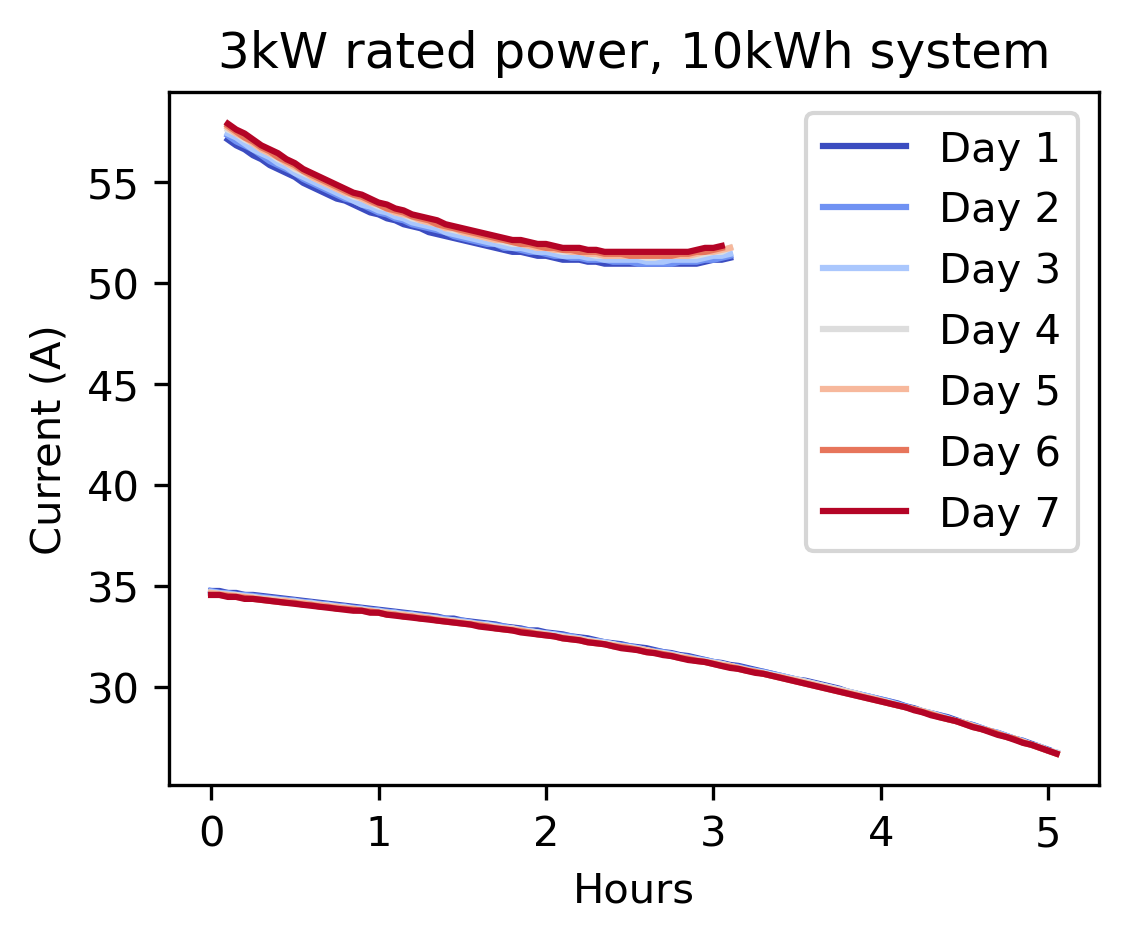

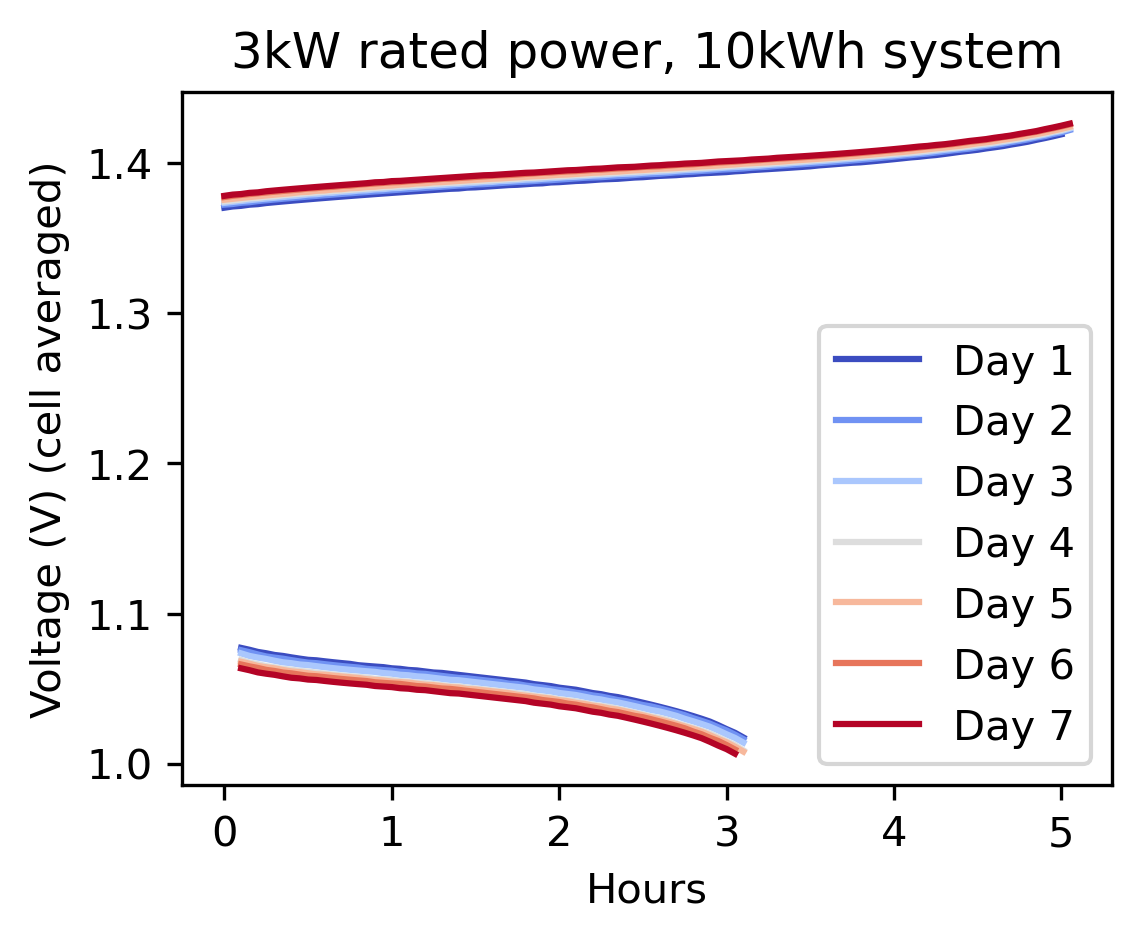

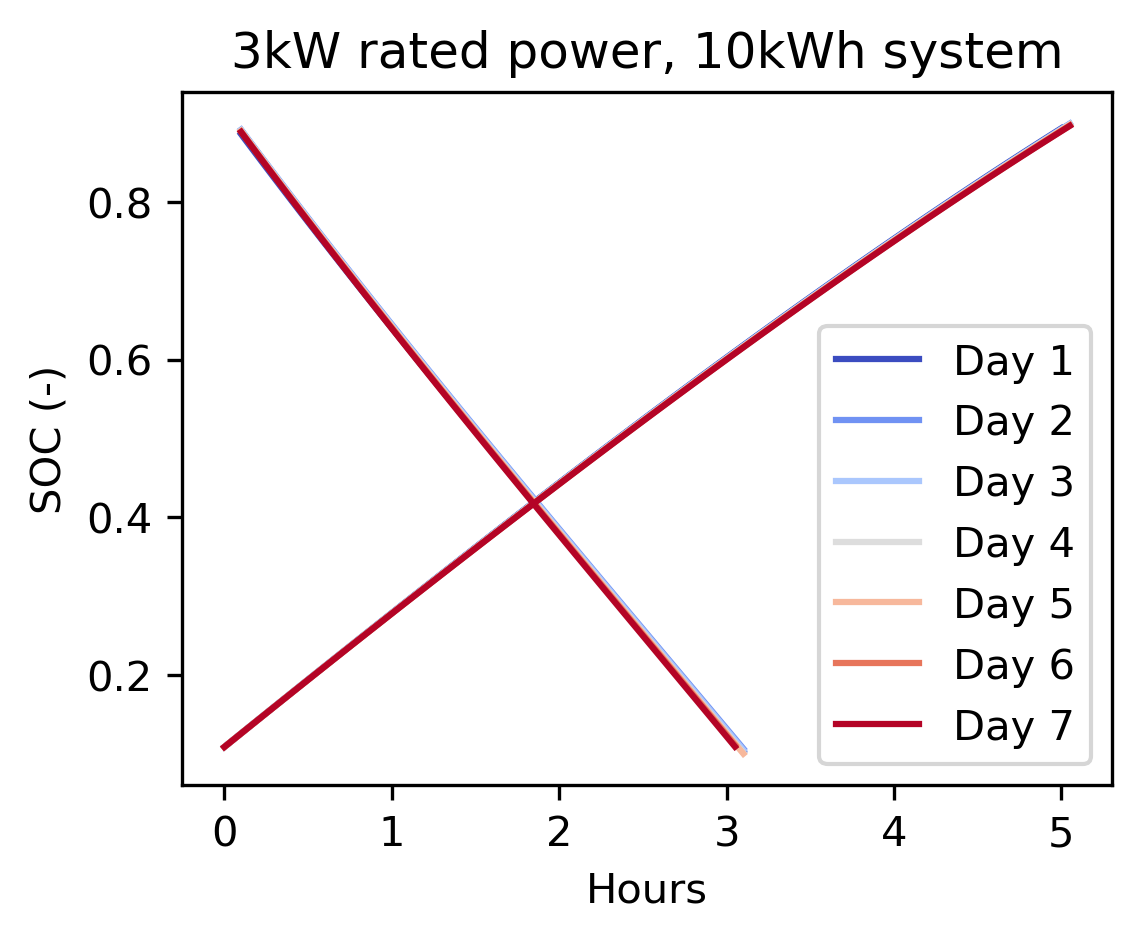

In [21]:
cmap = cm.get_cmap('coolwarm', 7) 

plt.figure(figsize=(4, 3),dpi=300)
for day in range(7):
    syn_hourss = results[day]['syn_hourss']
    syn_currents = results[day]['syn_currents']
    syn_soc = results[day]['syn_socs']    
    discharge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    discharge_currents = np.array([syn_currents[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    charge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if syn_currents[i] < 0 and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    charge_currents = np.array([syn_currents[i] for i in range(len(syn_currents)) if (syn_currents[i] < 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    color = cmap(day)
    plt.plot(discharge_hourss - charge_hourss[-1], discharge_currents, color=color)
    plt.plot(charge_hourss, abs(charge_currents), label=f'Day {day+1}', color=color)
plt.xlabel('Hours')
plt.ylabel('Current (A)')
plt.title('3kW rated power, 10kWh system')
plt.legend()
plt.show()

plt.figure(figsize=(4, 3),dpi=300)
for day in range(7):
    syn_hourss = results[day]['syn_hourss']
    syn_currents = results[day]['syn_currents']
    syn_soc = results[day]['syn_socs']  
    syn_vs = results[day]['syn_vs']
    discharge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    discharge_vs = np.array([syn_vs[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])    
    charge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if syn_currents[i] < 0 and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    charge_vs = np.array([syn_vs[i] for i in range(len(syn_currents)) if syn_currents[i] < 0 and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    color = cmap(day)
    plt.plot(discharge_hourss - charge_hourss[-1], discharge_vs, color=color)
    plt.plot(charge_hourss, charge_vs, label=f'Day {day+1}', color=color)
plt.xlabel('Hours')
plt.ylabel('Voltage (V) (cell averaged)')
plt.title('3kW rated power, 10kWh system')
plt.legend()
plt.show()

plt.figure(figsize=(4, 3),dpi=300)
for day in range(7):
    syn_hourss = results[day]['syn_hourss']
    syn_currents = results[day]['syn_currents']
    syn_soc = results[day]['syn_socs']
    discharge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    discharge_socs = np.array([syn_soc[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])   
    charge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if syn_currents[i] < 0 and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    charge_socs = np.array([syn_soc[i] for i in range(len(syn_currents)) if syn_currents[i] < 0 and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    color = cmap(day)
    time_charge=charge_hourss[-1]
    time_discharge=discharge_hourss[-1] - charge_hourss[-1]
    rte=time_discharge/time_charge
    plt.plot(discharge_hourss - charge_hourss[-1], discharge_socs, color=color)
    plt.plot(charge_hourss, charge_socs, label=f'Day {day+1}', color=color)
plt.xlabel('Hours')
plt.ylabel('SOC (-)')
plt.title('3kW rated power, 10kWh system')
plt.legend()
plt.show()